In [1]:
# imports
import altair as alt
from traffic.core import Traffic
from traffic.core.projection import EuroPP
from deep_traffic_generation.core.utils import extract_features

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import traj_dist.distance as tdist

from tqdm import tqdm

from deep_traffic_generation.core.utils import compare_xy, cumul_dist_plot

import warnings
warnings.filterwarnings("ignore")

Reference trajectories from landing_zurich_2019

In [2]:
t_ref = (
    Traffic.from_file("../deep_traffic_generation/data/traffic_15.pkl")
)
t_ref

,count
flight_id,
ABP721_057,200
SWR134J_9747,200
SWR134J_9730,200
SWR134J_9731,200
SWR134J_9732,200
SWR134J_9733,200
SWR134J_9734,200
SWR134J_9736,200
SWR134J_9737,200


Simulation from Douglas-Peucker simplification

In [3]:
t_ref_dp = (
    Traffic.from_file("./outputs/dp_ref.csv")
    .drop(columns=["Unnamed: 0"])
)
dp_t_sim = (
    Traffic.from_file("./outputs/dp_ref_sim.csv")
    .assign(
        flight_id=lambda df: df.flight_id.astype(str),
        callsign=lambda df: df.flight_id.astype(str),
        icao24=lambda df: df.flight_id.astype(str),
    )
)
dp_t_sim

,count
flight_id,
EWG56L_5010,90
SAS99R_7717,90
SWR109R_8490,90
SWR124P_9374,90
SWR108Z_8354,90
SWR73N_16251,90
CPA383_2166,90
SWR105K_8237,90
SWR197_12253,90


In [4]:
t_ref_nav = (
    Traffic.from_file("./outputs/nav_ref.csv")
    .drop(columns=["Unnamed: 0"])
)
nav_t_sim = (
    Traffic.from_file("./outputs/nav_ref_sim.csv")
    .assign(
        flight_id=lambda df: df.flight_id.astype(str),
        callsign=lambda df: df.flight_id.astype(str),
        icao24=lambda df: df.flight_id.astype(str),
    )
)
nav_t_sim

,count
flight_id,
SWR116W_8833,66
SWR134J_9739,62
SWR1271_9444,61
SWR197_12265,61
SWR145N_10188,60
SWR1189_8980,59
SWR915_17457,59
DLH8NJ_2823,58
SWR116W_8803,58


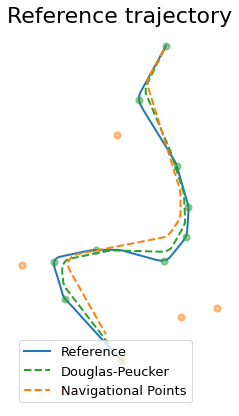

In [5]:
highlight = "SWR116W_8833"

with plt.style.context("traffic"):
    ax = plt.axes(projection=EuroPP())
    ax.set_title("Reference trajectory")
    t_ref[highlight].plot(ax, c="tab:blue", lw=2.0, label="Reference")
    # Douglas-Peucker
    t_ref_dp[highlight].plot(ax, mec="tab:green",mew=3.0,ms=10.0, mfc="none", marker=".", ls="", alpha=0.6)
    dp_t_sim[highlight].plot(ax, c="tab:green", ls="--", lw=2.0, label="Douglas-Peucker")
    # Navigational Points
    t_ref_nav[highlight].plot(ax, mec="tab:orange",mew=3.0,ms=10.0, mfc="none", marker=".", ls="", alpha=0.6)
    nav_t_sim[highlight].plot(ax, c="tab:orange", ls="--", lw=2.0, label="Navigational Points")
    ax.legend(loc=0)

### Distance Computing

In [6]:
summary = t_ref.summary(["flight_id", "callsign", "icao24", "start", "duration"])
dp_t_sim = dp_t_sim.merge(summary, on="flight_id")
t_s = dp_t_sim.summary(["flight_id", "timestamp_min"])
dp_t_sim = dp_t_sim.merge(t_s, on="flight_id").assign(
    timestamp= lambda df: df.start + (df.timestamp - df.timestamp_min) * pd.Timedelta("1s")
).compute_xy(EuroPP())
df_dp = compare_xy(dp_t_sim, t_ref)
df_dp.to_csv("./outputs/distances/dist_ref_dp.csv")

100%|██████████| 3968/3968 [13:08<00:00,  5.03it/s]


In [7]:
summary = t_ref.summary(["flight_id", "callsign", "icao24", "start", "duration"])
nav_t_sim = nav_t_sim.merge(summary, on="flight_id")
t_s = nav_t_sim.summary(["flight_id", "timestamp_min"])
nav_t_sim = nav_t_sim.merge(t_s, on="flight_id").assign(
    timestamp= lambda df: df.start + (df.timestamp - df.timestamp_min) * pd.Timedelta("1s")
).compute_xy(EuroPP())
df_nav = compare_xy(nav_t_sim, t_ref)
df_nav.to_csv("./outputs/distances/dist_ref_nav.csv")

100%|██████████| 3968/3968 [12:49<00:00,  5.16it/s]


In [8]:
df = pd.concat(
        [
            df_dp.assign(
                generation="Reference", reconstruction="Douglas-Peucker"
            ),
            df_nav.assign(
                generation="Reference", reconstruction="Navigational Points"
            )
        ]
    )
cumul_dist_plot(df, scales = dict(dtw=(0, 1.2e6), sspd=(0, 1.5e4)))

alt.VConcatChart(...)